# Assignment 3: DBSCAN

## Problem Statement:
Triage is the process of prioritizing patient care (or disaster victims) based on severity, symptoms, prognosis, and resource availability. The goal is to identify patients requiring immediate resuscitation, assign patients to appropriate care areas, and initiate necessary diagnostic or therapeutic measures. As a data scientist, your task is to cluster the patients according to their symptoms and assign urgency levels to each group. It is critical that patients in need of immediate resuscitation are accurately identified. 

## 1. Data Analysis and Preparation

## 1.a Load and Summarize Data
- Load required libraries
- Load `patient_priority.csv` into a pandas DataFrame.
- Drop "triage" column and print the header using `DataFrame.head()`.
- Print a summary using `DataFrame.describe()`.

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [21]:
url = "https://raw.githubusercontent.com/Hunteracademic/Unsupervised_assignment_1/master/patient_priority.csv"
patient_priority_raw = pd.read_csv(url)
patient_priority = patient_priority_raw.drop("triage", axis=1)
patient_priority.head()

,Unnamed: 0,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status
0,0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,Urban,never smoked
1,1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,Urban,never smoked
2,2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,Urban,never smoked
3,3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,Urban,never smoked
4,4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,Urban,never smoked


In [22]:
patient_priority.describe()

,Unnamed: 0,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease
count,6962.000000,6962.000000,6961.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000
mean,2011.954180,57.450014,0.531964,0.529015,109.629991,184.711290,163.502442,0.061764,98.394283,56.813416,111.091640,27.190908,0.467386,0.071531,0.039500
std,1560.966466,11.904948,0.499013,1.253791,21.534852,32.010359,15.458693,0.240743,28.598084,22.889316,17.470033,7.362886,0.102663,0.257729,0.194796
min,0.000000,28.000000,0.000000,0.000000,60.000000,150.000000,138.000000,0.000000,55.120000,21.000000,81.000000,10.300000,0.078000,0.000000,0.000000
25%,604.000000,48.000000,0.000000,0.000000,92.000000,164.000000,150.000000,0.000000,78.707500,36.000000,97.000000,21.800000,0.467386,0.000000,0.000000
50%,1628.500000,56.000000,1.000000,0.000000,111.000000,179.000000,163.000000,0.000000,93.000000,55.000000,111.000000,26.200000,0.467386,0.000000,0.000000
75%,3368.750000,66.000000,1.000000,0.000000,127.000000,192.000000,177.000000,0.000000,111.632500,77.000000,125.000000,31.000000,0.467386,0.000000,0.000000
max,5109.000000,82.000000,1.000000,4.000000,165.000000,294.000000,202.000000,1.000000,199.000000,99.000000,171.000000,66.800000,2.420000,1.000000,1.000000


**Use `DataFrame.describe()` to summarize the dataset.**

- There are 15 different columns with numerical data that descriptive statistics can use. 
- Notable there are 6962 different records in this dataset that represent each row. 


**Explain the meaning of each column.**


- **Unnamed: 0**: This looks like an index column identifying unique patients (however it seems there may be duplicates)
- **age**: Patient age in years
- **gender**: Recorded sex at birth
- **chest pain type**: Encoded category of chest pain (e.g., typical/atypical/none, represented as 1–4
- **blood pressure**: Resting blood pressure
- **cholesterol**: Serum cholesterol level
- **max heart rate**: Maximum heart rate achieved during testing
- **exercise angina**: Presence of exercise‑induced angina (0 = no, 1 = yes)
- **plasma glucose**: Plasma glucose concentration
- **skin_thickness**: Triceps skinfold thickness in mm
- **insulin**: Serum insulin level
- **bmi**:  Body mass index
- **diabetes_pedigree**: Diabetes pedigree function (family diabetes history metric)
- **hypertension**: Indicator for high blood pressure (0 = no, 1 = yes)
- **heart_disease**: Indicator for diagnosed heart disease (0 = no, 1 = yes)
- **Residence_type**: Patient residence type
- **smoking_status**: Smoking status history

**Make observations based on the summary statistics.**

- The ages in this group go from the early 30s all the way to over 80, but most people are in their 50s to 70s. This makes sense since you'd usually see older people in a heart or diabetes clinic

- Even though some people have high blood pressure or lipids, the "hypertension" and "heart disease" labels are often marked as 0. This could mean they haven't been officially diagnosed yet or they are just in for a screening

- The data shows people living in both Urban and Rural areas, so we can compare if where they live changes their health


## 1.b Cleaning
- Using `info()` to deternmine data types and missing values
- Check duplicates
- Clearning process

In [23]:
patient_priority.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962 entries, 0 to 6961
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6962 non-null   int64  
 1   age                6962 non-null   float64
 2   gender             6961 non-null   float64
 3   chest pain type    6962 non-null   float64
 4   blood pressure     6962 non-null   float64
 5   cholesterol        6962 non-null   float64
 6   max heart rate     6962 non-null   float64
 7   exercise angina    6962 non-null   float64
 8   plasma glucose     6962 non-null   float64
 9   skin_thickness     6962 non-null   float64
 10  insulin            6962 non-null   float64
 11  bmi                6962 non-null   float64
 12  diabetes_pedigree  6962 non-null   float64
 13  hypertension       6962 non-null   float64
 14  heart_disease      6962 non-null   float64
 15  Residence_type     6962 non-null   object 
 16  smoking_status     6962 

In [24]:
print("--- Duplicate Rows Report ---")
print(f"Duplicates found: {patient_priority.duplicated().sum()}")

print("-" * 30) # Prints a line of 30 dashes

print("--- Missing Values Report ---")
print(patient_priority.isna().sum()[patient_priority.isna().sum() > 0])

--- Duplicate Rows Report ---
Duplicates found: 0
------------------------------
--- Missing Values Report ---
gender    1
dtype: int64


In [25]:
patient_priority_clean = patient_priority.dropna()

Inspecting the column `Unnamed: 0` to understand its meaning and duplicated values:

In [26]:
dup_rows_col = patient_priority_clean[patient_priority_clean.duplicated(subset=["Unnamed: 0"], keep=False)]
dups_col = patient_priority_clean[
    patient_priority_clean.duplicated(subset=["Unnamed: 0"], keep=False)
].sort_values(by=["Unnamed: 0"])

print(dups_col)

      Unnamed: 0   age  gender  chest pain type  blood pressure  cholesterol  \
2              2  37.0     1.0              2.0           130.0        294.0   
1854           2  80.0     1.0              0.0           128.0        179.0   
1855           3  49.0     0.0              0.0            80.0        199.0   
3              3  48.0     0.0              4.0           138.0        214.0   
1139           3  50.0     1.0              0.0            66.0        195.0   
...          ...   ...     ...              ...             ...          ...   
3039        1187  43.0     1.0              0.0           129.0        171.0   
3040        1188  62.0     1.0              0.0           128.0        189.0   
1137        1188  57.0     0.0              2.0           130.0        236.0   
1138        1189  38.0     1.0              3.0           138.0        175.0   
3041        1189  73.0     1.0              0.0           121.0        184.0   

      max heart rate  exercise angina  

### Conclusion:

- Due to only having one row with missing data we decided to drop it as our current dataset still has 6961 to analyze which is plenty

- After inspecting the "Unnamed" 0" column it seems like the values in it are not primary keys/unique identifiers. Due to no available context on that column or any obvious pattern to follow we decided to drop it

In [27]:
patient_priority_clean.drop(columns=["Unnamed: 0"], inplace=True)
patient_priority_clean.head()

C:\Users\gly3\AppData\Local\Temp\ipykernel_15404\2128965378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_priority_clean.drop(columns=["Unnamed: 0"], inplace=True)


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status
0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,Urban,never smoked
1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,Urban,never smoked
2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,Urban,never smoked
3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,Urban,never smoked
4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,Urban,never smoked


## 1.c Encoding
First of all, we want to check the distribution of our `object` type columns

In [28]:
patient_priority['smoking_status'].value_counts()

smoking_status
never smoked       3745
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

After analysis, we decided to encode these columns using `pd.get_dummies()`, setting the `drop_first` parameter to `True`, getting rid of the column that represents a linear combination of the others and therefore, would affect the performance of the model in future steps.

In [29]:
patient_priority_enc = pd.get_dummies(
    patient_priority_clean,
    columns=["Residence_type", "smoking_status"],
    drop_first=True,
    dtype=int
)
patient_priority_enc.head()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,1,0,1,0
1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,1,0,1,0
2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,1,0,1,0
3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,1,0,1,0
4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,1,0,1,0


## 1.d Visualization

### Heatmap

Text(0.5, 1.0, 'Correlation Heatmap of Patient Priority Data')

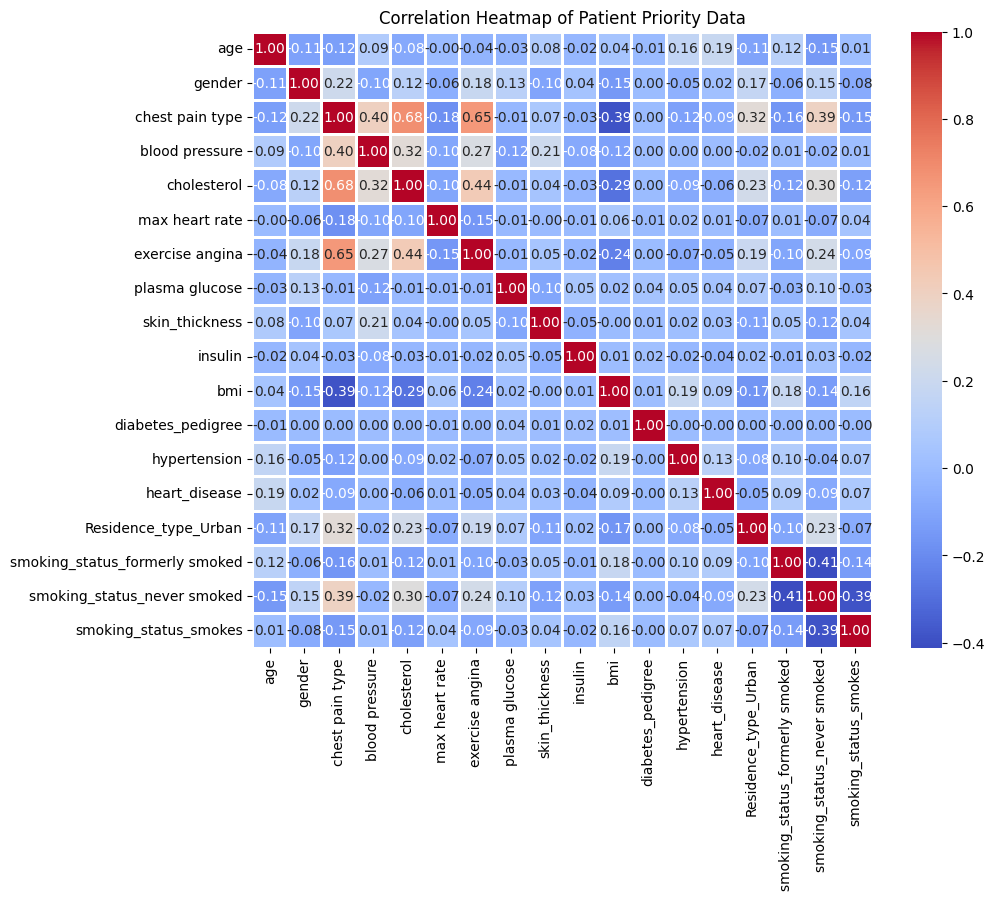

In [30]:
corr = patient_priority_enc.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=1
)
plt.title("Correlation Heatmap of Patient Priority Data")

### Pairplots

In [31]:
# sns.pairplot(patient_priority_enc)

### Observations:
- High levels of cholesterol seem to be related to the type of chest pain of the patient (positive relationship 0.68)
- There is a slight negative correlation between variables such as `bmi` and `chest_pain_type`
- For smoking variables, there are negative correlations between people that never smoked and people who actually smoke, which was expected considering that if one of those variables increases the other is forced to decrease in the same dataset.
- Not important correlations between any other features.


# 2. Modeling
## 2.a Scaling

In [32]:
scaler = MinMaxScaler()
# Fit dataset into new variable using scaler
scaled_x = scaler.fit_transform(patient_priority_enc)
# create dataframe with index and column names
df_scaled = pd.DataFrame(scaled_x, columns=patient_priority_enc.columns, index=patient_priority_enc.index)
df_scaled.head()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.222222,1.0,0.50,0.761905,1.000000,0.53125,0.0,0.367528,0.282051,0.122222,0.153982,0.166262,0.0,0.0,1.0,0.0,1.0,0.0
1,0.388889,0.0,0.75,0.952381,0.208333,0.28125,0.0,0.138171,0.333333,0.100000,0.136283,0.166262,0.0,0.0,1.0,0.0,1.0,0.0
2,0.166667,1.0,0.50,0.666667,1.000000,0.28125,0.0,0.298026,0.410256,0.233333,0.224779,0.166262,0.0,0.0,1.0,0.0,1.0,0.0
3,0.370370,0.0,1.00,0.742857,0.444444,0.28125,1.0,0.117320,0.384615,0.411111,0.136283,0.166262,0.0,0.0,1.0,0.0,1.0,0.0
4,0.481481,1.0,0.75,0.857143,0.312500,0.28125,0.0,0.367528,0.884615,0.022222,0.189381,0.166262,0.0,0.0,1.0,0.0,1.0,0.0


## 2.b Testing different parameters values (grid use) 

Use sklearn.cluster.DBSCAN to cluster the data. Create at least 10 different models using various hyperparameter combinations (eps, min_samples, metric, p). Calculate the silhouette score for each model and tabulate the results. 

To solve this, we decided to test different epsilon values using lists that would create different grid combinations. These combinations are being executed by an auxiliar function that prints the results. Our goal is to narrow our search grid down to the best **10** models we would like to test, in terms of % of noise, number of clusters and silhouette score.

In [33]:
small_eps      = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
small_samples  = [5, 10, 15, 20, 25]
high_samples   = [30, 35, 40, 45, 50]
giant_samples  = [90, 100, 150, 160, 170, 174, 200]
metrics = ['euclidean', 'manhattan', 'chebyshev']

n_records = scaled_x.shape[0]
max_noise_ratio = 0.25 # Setting up a maximum level of noise acceptable for a clustering to be considered valid

def run_grid(eps_list, samples_list, metrics, verbose=True):
    """ Running the grid search on defined parameters. Only prints results
    that contain more than 2 clusters for quality purposes

    Args:
        eps_list (list): Different epsilon values to try
        samples_list (list): Different min_samples to try
        metrics (list): The distance metrics to use
        name (str): The name of the combination when printed
    Returns:
        list: DataFrame with all the results that passed the filters
    """
    results = []
    for metric in metrics:
        if verbose:
            print(f"\n=== metric={metric} ===")
        for eps in eps_list:
            for ms in samples_list:
                db = DBSCAN(eps=eps, min_samples=ms, metric=metric)
                labels = db.fit_predict(scaled_x)

                n_clusters = len(set(labels) - {-1})
                n_noise = np.sum(labels == -1)
                noise_ratio = n_noise / n_records

                # compute silhouette only if ≥2 clusters (ignoring noise)
                labels_no_noise = labels[labels != -1]
                X_no_noise = scaled_x[labels != -1]
                if len(np.unique(labels_no_noise)) >= 2:
                    sil = silhouette_score(X_no_noise, labels_no_noise, metric=metric)
                else:
                    sil = None

                # apply filters:
                if sil is not None and noise_ratio <= max_noise_ratio:
                    if verbose:
                        print(
                            f"eps={eps}, min_samples={ms}, "
                            f"clusters={n_clusters}, noise={n_noise} "
                            f"({noise_ratio:.2%}), silhouette={sil:.4f}"
                        )
                    # Storing in a dict for later use
                    results.append({
                        "metric": metric,
                        "eps": eps,
                        "min_samples": ms,
                        "n_clusters": n_clusters,
                        "n_noise": n_noise,
                        "noise_ratio": noise_ratio,
                        "silhouette": sil,
                        "labels": labels
                    })
    return results

In [34]:
# Execution with small eps and small samples, testing all metrics
run_grid(small_eps, small_samples, metrics)


=== metric=euclidean ===
eps=0.7, min_samples=5, clusters=48, noise=111 (1.59%), silhouette=0.3378
eps=0.7, min_samples=10, clusters=39, noise=229 (3.29%), silhouette=0.3381
eps=0.7, min_samples=15, clusters=27, noise=413 (5.93%), silhouette=0.3405
eps=0.7, min_samples=20, clusters=23, noise=494 (7.10%), silhouette=0.3393
eps=0.7, min_samples=25, clusters=21, noise=564 (8.10%), silhouette=0.3387
eps=0.8, min_samples=5, clusters=52, noise=55 (0.79%), silhouette=0.3385
eps=0.8, min_samples=10, clusters=43, noise=141 (2.03%), silhouette=0.3396
eps=0.8, min_samples=15, clusters=33, noise=275 (3.95%), silhouette=0.3403
eps=0.8, min_samples=20, clusters=26, noise=404 (5.80%), silhouette=0.3407
eps=0.8, min_samples=25, clusters=24, noise=451 (6.48%), silhouette=0.3405
eps=0.9, min_samples=5, clusters=56, noise=25 (0.36%), silhouette=0.3385
eps=0.9, min_samples=10, clusters=44, noise=113 (1.62%), silhouette=0.3397
eps=0.9, min_samples=15, clusters=36, noise=218 (3.13%), silhouette=0.3402
eps=

[{'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 5,
  'n_clusters': 48,
  'n_noise': np.int64(111),
  'noise_ratio': np.float64(0.01594598477230283),
  'silhouette': 0.33775233238693375,
  'labels': array([ 0,  1,  0, ..., 24, 17,  9], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 10,
  'n_clusters': 39,
  'n_noise': np.int64(229),
  'noise_ratio': np.float64(0.03289757218790404),
  'silhouette': 0.338127889430713,
  'labels': array([ 0,  1,  0, ..., 18, 12,  6], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 15,
  'n_clusters': 27,
  'n_noise': np.int64(413),
  'noise_ratio': np.float64(0.05933055595460422),
  'silhouette': 0.3404605763392854,
  'labels': array([ 0,  1,  0, ..., 16, 12,  6], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 20,
  'n_clusters': 23,
  'n_noise': np.int64(494),
  'noise_ratio': np.float64(0.07096681511277116),
  'silhouette': 0.3393057407072047,
  'labels': array([ 0,  1, 

In [35]:
# Execution with small eps and high samples, testing all metrics
run_grid(small_eps, high_samples,  metrics)


=== metric=euclidean ===
eps=0.7, min_samples=30, clusters=20, noise=614 (8.82%), silhouette=0.3406
eps=0.7, min_samples=35, clusters=19, noise=654 (9.40%), silhouette=0.3516
eps=0.7, min_samples=40, clusters=18, noise=699 (10.04%), silhouette=0.3521
eps=0.7, min_samples=45, clusters=17, noise=758 (10.89%), silhouette=0.3520
eps=0.7, min_samples=50, clusters=17, noise=758 (10.89%), silhouette=0.3520
eps=0.8, min_samples=30, clusters=22, noise=503 (7.23%), silhouette=0.3399
eps=0.8, min_samples=35, clusters=20, noise=582 (8.36%), silhouette=0.3413
eps=0.8, min_samples=40, clusters=19, noise=629 (9.04%), silhouette=0.3520
eps=0.8, min_samples=45, clusters=19, noise=633 (9.09%), silhouette=0.3520
eps=0.8, min_samples=50, clusters=18, noise=683 (9.81%), silhouette=0.3520
eps=0.9, min_samples=30, clusters=22, noise=500 (7.18%), silhouette=0.3403
eps=0.9, min_samples=35, clusters=21, noise=533 (7.66%), silhouette=0.3415
eps=0.9, min_samples=40, clusters=20, noise=575 (8.26%), silhouette=0.3

[{'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 30,
  'n_clusters': 20,
  'n_noise': np.int64(614),
  'noise_ratio': np.float64(0.08820571756931475),
  'silhouette': 0.3405815539175533,
  'labels': array([ 0,  1,  0, ..., 13, 11,  5], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 35,
  'n_clusters': 19,
  'n_noise': np.int64(654),
  'noise_ratio': np.float64(0.09395201838816263),
  'silhouette': 0.3516282518208881,
  'labels': array([ 0,  1,  0, ..., 12, 10,  4], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 40,
  'n_clusters': 18,
  'n_noise': np.int64(699),
  'noise_ratio': np.float64(0.10041660680936647),
  'silhouette': 0.35212753798845364,
  'labels': array([ 0,  1,  0, ..., 12, 10,  4], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 45,
  'n_clusters': 17,
  'n_noise': np.int64(758),
  'noise_ratio': np.float64(0.10889240051716707),
  'silhouette': 0.3520042063223709,
  'labels': array([ 0,  1

In [36]:
# Execution with small eps and giant samples, testing all metrics
run_grid(small_eps, giant_samples,  metrics)


=== metric=euclidean ===
eps=0.7, min_samples=90, clusters=16, noise=898 (12.90%), silhouette=0.3519
eps=0.7, min_samples=100, clusters=16, noise=931 (13.37%), silhouette=0.3525
eps=0.8, min_samples=90, clusters=17, noise=757 (10.87%), silhouette=0.3520
eps=0.8, min_samples=100, clusters=17, noise=757 (10.87%), silhouette=0.3520
eps=0.8, min_samples=150, clusters=13, noise=1329 (19.09%), silhouette=0.3484
eps=0.8, min_samples=160, clusters=13, noise=1337 (19.21%), silhouette=0.3487
eps=0.8, min_samples=170, clusters=13, noise=1341 (19.26%), silhouette=0.3488
eps=0.8, min_samples=174, clusters=12, noise=1514 (21.75%), silhouette=0.3473
eps=0.9, min_samples=90, clusters=17, noise=756 (10.86%), silhouette=0.3519
eps=0.9, min_samples=100, clusters=17, noise=756 (10.86%), silhouette=0.3519
eps=0.9, min_samples=150, clusters=14, noise=1168 (16.78%), silhouette=0.3491
eps=0.9, min_samples=160, clusters=13, noise=1327 (19.06%), silhouette=0.3482
eps=0.9, min_samples=170, clusters=13, noise=13

[{'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 90,
  'n_clusters': 16,
  'n_noise': np.int64(898),
  'noise_ratio': np.float64(0.1290044533831346),
  'silhouette': 0.3519131691896923,
  'labels': array([ 0,  1,  0, ...,  8, -1,  7], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.7,
  'min_samples': 100,
  'n_clusters': 16,
  'n_noise': np.int64(931),
  'noise_ratio': np.float64(0.1337451515586841),
  'silhouette': 0.3525021006895342,
  'labels': array([ 0,  2,  0, ...,  7, -1,  6], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.8,
  'min_samples': 90,
  'n_clusters': 17,
  'n_noise': np.int64(757),
  'noise_ratio': np.float64(0.10874874299669587),
  'silhouette': 0.3519725916961273,
  'labels': array([ 0,  1,  0, ..., 10, 15,  4], shape=(6961,))},
 {'metric': 'euclidean',
  'eps': 0.8,
  'min_samples': 100,
  'n_clusters': 17,
  'n_noise': np.int64(757),
  'noise_ratio': np.float64(0.10874874299669587),
  'silhouette': 0.3519725916961273,
  'labels': array([ 0,  1,

Looking at the results, we can discard some grid groups:
- **Small Samples:** This group of hyperparameters was generating too many clusters in general, a couple models had less clusters but a very bad silhouette score, and when plotted externally, would provide very bad cluster distribution
- **High Samples:** This group of hyperparameters either generating too many clusters or very bad silhouette scores.

We ended up picking **giant samples** using the **euclidean** distance metric (eps between 0.8 and 1.0 as well as min samples between 170 and 200), as these would give a better balance between scores, # of clusters and distribution when tested with still acceptable **noise** values. In the next cell, we will test this grid in more detail and store in in a dataframe for analysis purposes:

In [37]:
focus_eps = [0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0]
focus_samples = [170, 172, 174, 176, 178, 180, 185, 190, 195, 200]

fine_tuning_df = run_grid(focus_eps, focus_samples, ['euclidean'], verbose=False) # Dont print this time
fine_tuning_df = pd.DataFrame(fine_tuning_df)
results_df = fine_tuning_df.copy() # Copy with labels
results_df.set_index(['eps', 'min_samples'], inplace=True)

In [38]:
fine_tuning_df = fine_tuning_df.drop(columns=['labels']) # Drop labels column to make it easier to read the DataFrame

In [39]:
filter_1_df = fine_tuning_df[fine_tuning_df['noise_ratio'] <= 0.24].sort_values(by='n_clusters', ascending=True).head(20)
filter_2_df = filter_1_df.sort_values(by='noise_ratio', ascending=True)
filter_2_df

,metric,eps,min_samples,n_clusters,n_noise,noise_ratio,silhouette
52,euclidean,0.90,180,12,1508,0.216636,0.346897
53,euclidean,0.90,185,12,1508,0.216636,0.346897
63,euclidean,0.92,185,12,1508,0.216636,0.346897
73,euclidean,0.94,185,12,1508,0.216636,0.346897
42,euclidean,0.88,180,12,1508,0.216636,0.346897
31,euclidean,0.86,178,12,1508,0.216636,0.346897
32,euclidean,0.86,180,12,1508,0.216636,0.346897
43,euclidean,0.88,185,12,1508,0.216636,0.346897
93,euclidean,0.98,185,12,1508,0.216636,0.346897
94,euclidean,0.98,190,12,1508,0.216636,0.346897


## 3.c Selecting a model

In [40]:
label = results_df.loc[(0.80, 174), 'labels'] # Get the labels for the best combination of eps and min_samples
df_scaled["cluster"] = label
mask = label != -1
sil_score = silhouette_score(scaled_x[mask], label[mask], metric="euclidean")
sil_score

0.3472641011191838

<Axes: xlabel='cluster', ylabel='count'>

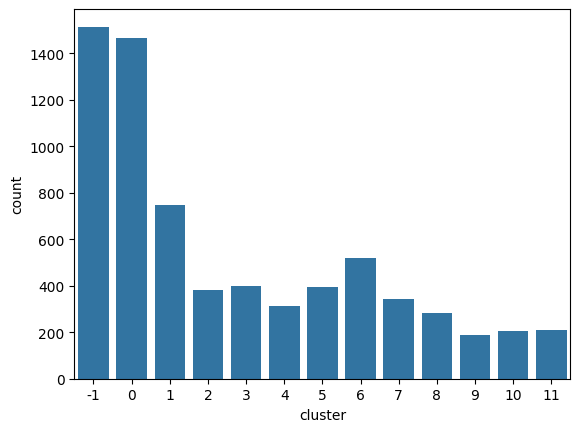

In [41]:
sns.countplot(df_scaled, x="cluster")

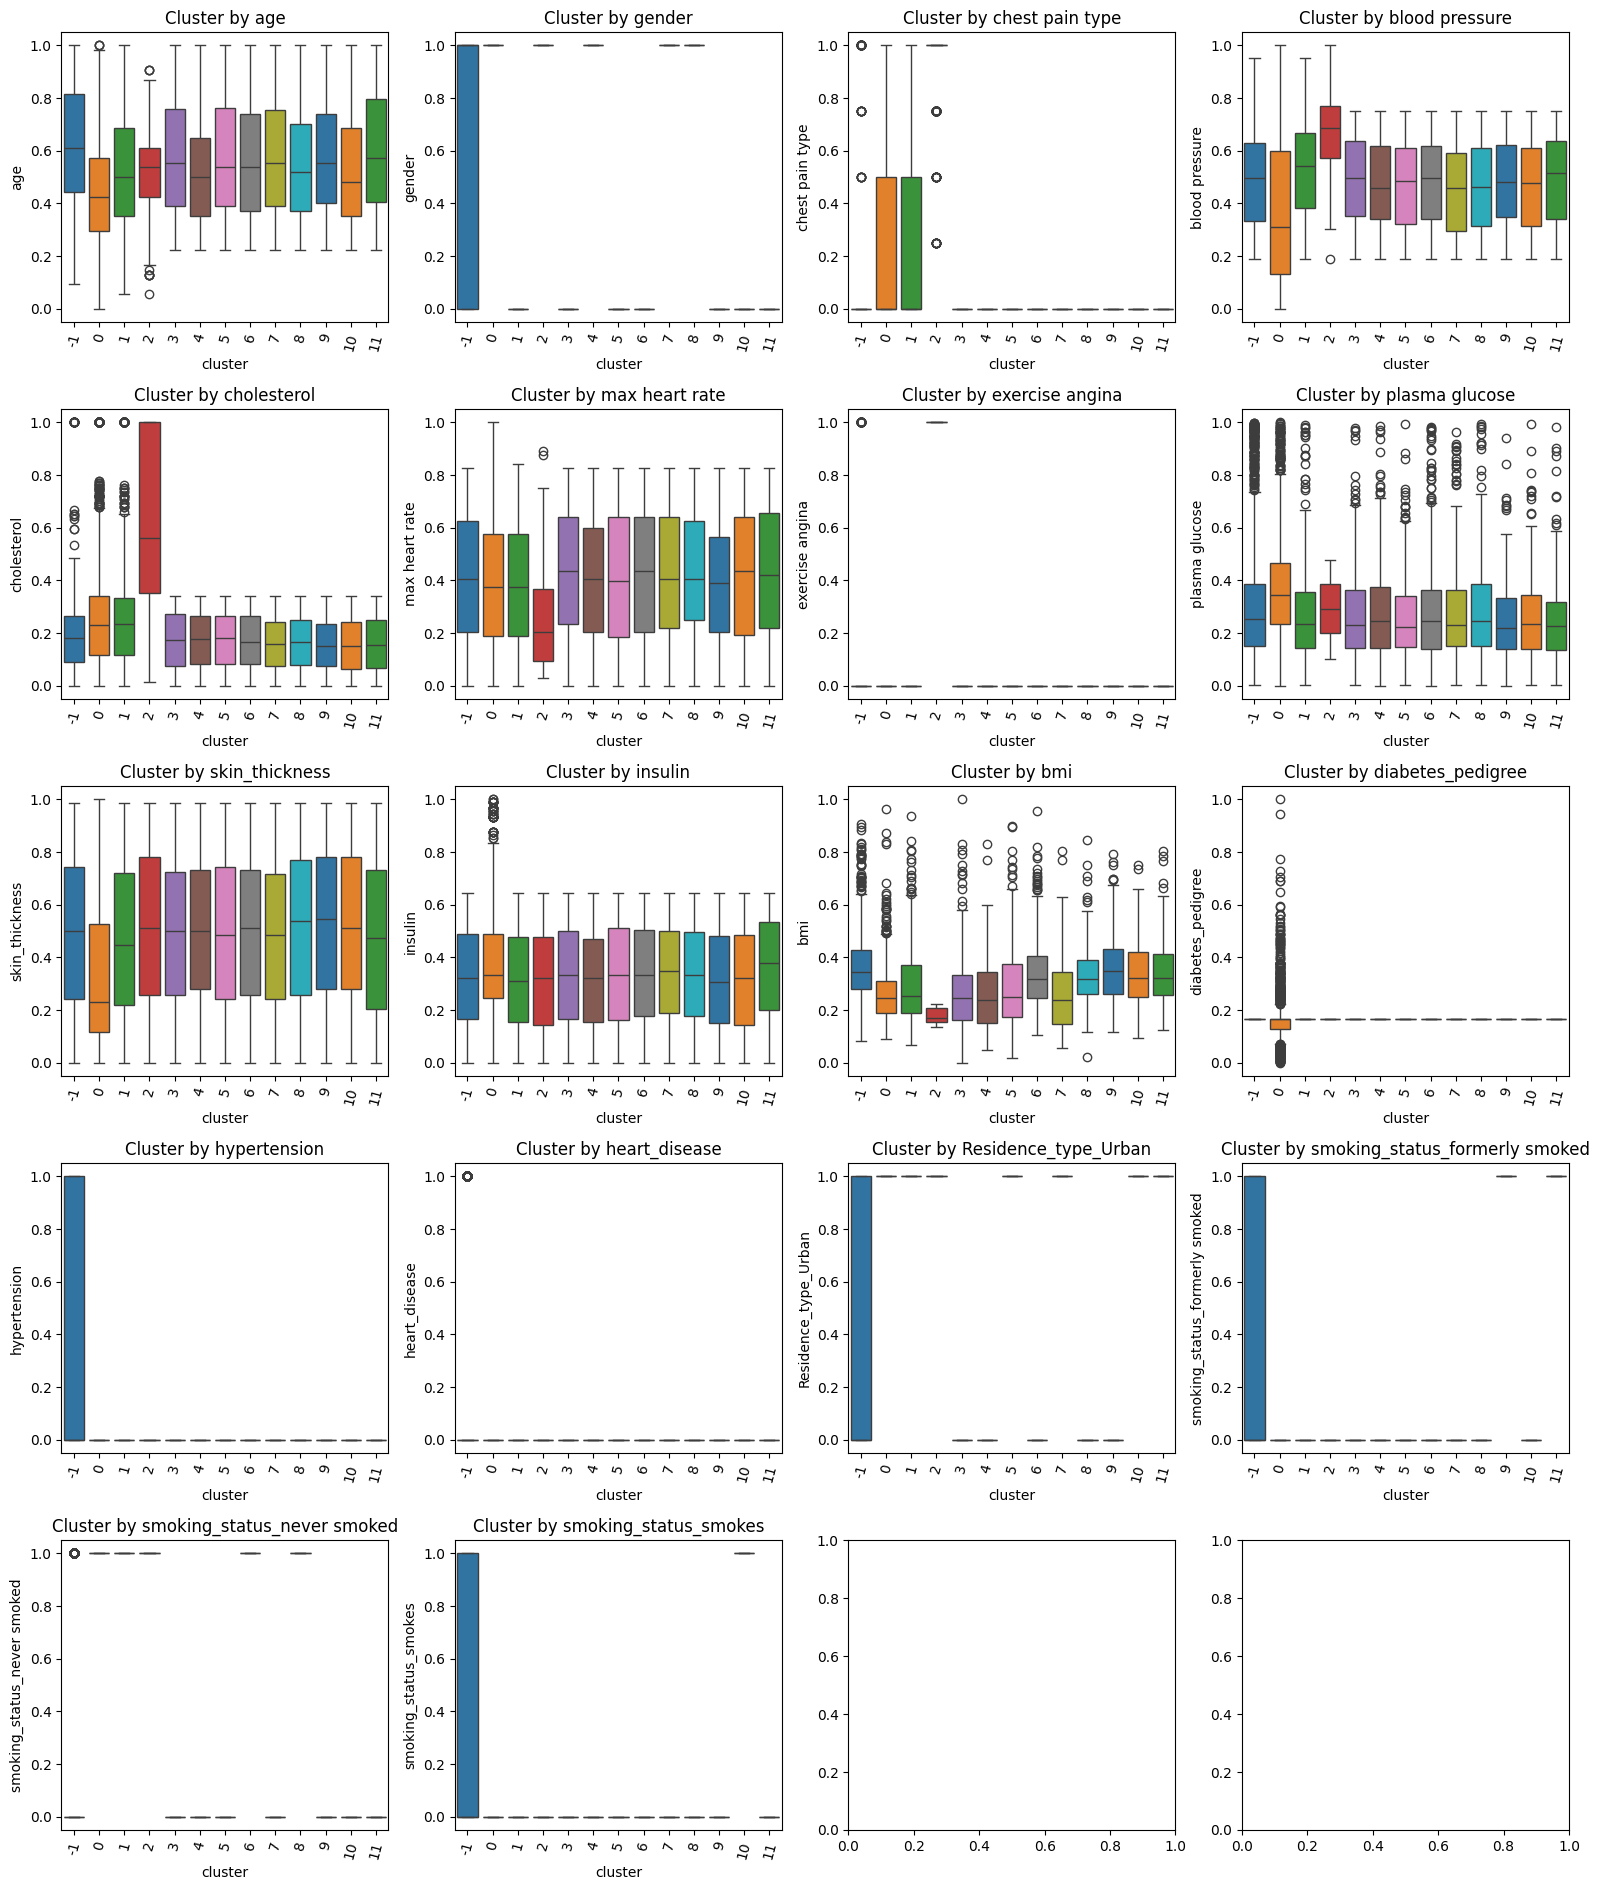

In [42]:
features = df_scaled.columns.tolist()
features.remove('cluster')
features
# For removing noise
df_scaled_no_noise = df_scaled[df_scaled['cluster']!=-1]

_, axes = plt.subplots(5, 4, figsize=(16, 19))
axes = axes.flatten()
for idx, feature in enumerate(features):
    sns.boxplot(data=df_scaled, x='cluster', y=feature, hue='cluster', palette='tab10', ax=axes[idx], legend=False)
    axes[idx].set_title(f"Cluster by {feature}")
    axes[idx].tick_params(axis='x', labelrotation=75)
plt.tight_layout()
plt.show()

<Axes: xlabel='chest pain type', ylabel='cholesterol'>

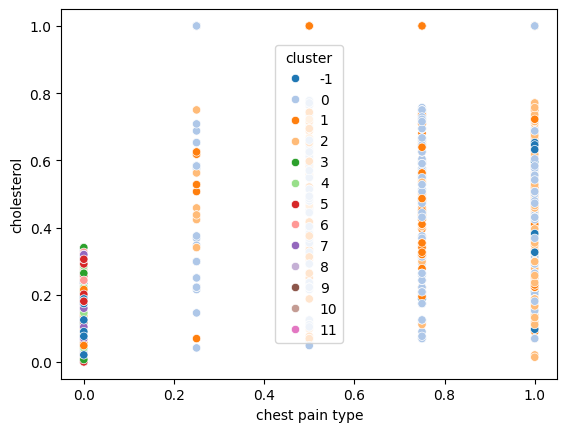

In [43]:
sns.scatterplot(df_scaled, x='chest pain type',y='cholesterol' ,hue='cluster', palette='tab20')

<Axes: xlabel='blood pressure', ylabel='cholesterol'>

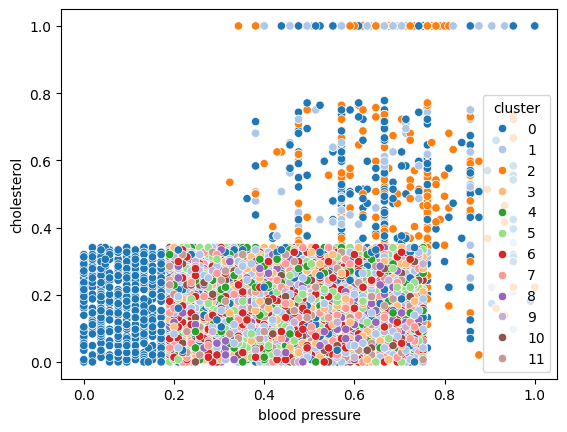

In [44]:
sns.scatterplot(df_scaled_no_noise, x='blood pressure',y='cholesterol' ,hue='cluster', palette='tab20')

In [45]:
summary = (
    df_scaled[df_scaled["cluster"] != -1]
    .groupby("cluster")
    .agg({
        "age": "median",
        "blood pressure": "median",
        "cholesterol": "median",
        "max heart rate": "median",
        "plasma glucose": "median",
        "bmi": "median",
        "hypertension": "mean",
        "Residence_type_Urban": "mean",
        "smoking_status_formerly smoked": "mean",
        "smoking_status_never smoked": "mean",
        "smoking_status_smokes": "mean",
    })
    .round(3)
)

summary

,age,blood pressure,cholesterol,max heart rate,plasma glucose,bmi,hypertension,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
cluster,,,,,,,,,,,
0,0.426,0.310,0.229,0.375,0.347,0.246,0.0,1.0,0.0,1.0,0.0
1,0.500,0.543,0.236,0.375,0.235,0.253,0.0,1.0,0.0,1.0,0.0
2,0.537,0.686,0.562,0.203,0.291,0.172,0.0,1.0,0.0,1.0,0.0
3,0.556,0.495,0.174,0.438,0.230,0.246,0.0,0.0,0.0,0.0,0.0
4,0.500,0.457,0.177,0.406,0.245,0.240,0.0,0.0,0.0,0.0,0.0
5,0.537,0.486,0.181,0.398,0.223,0.251,0.0,1.0,0.0,0.0,0.0
6,0.537,0.495,0.167,0.438,0.248,0.317,0.0,0.0,0.0,1.0,0.0
7,0.556,0.457,0.160,0.406,0.232,0.237,0.0,1.0,0.0,0.0,0.0
8,0.519,0.462,0.167,0.406,0.246,0.318,0.0,0.0,0.0,1.0,0.0


### C. Select the best model for this use case and justify your choice in Markdown. If initial models do not produce meaningful clusters, try additional hyperparameter settings and document any iterations and observations. 


# Conclusions
### A. 
Choose a pair of features and generate a scatter plot of the data, coloring points according to the clusters assigned by your best model. Comment on the plot in Markdown.


<Axes: xlabel='blood pressure', ylabel='cholesterol'>

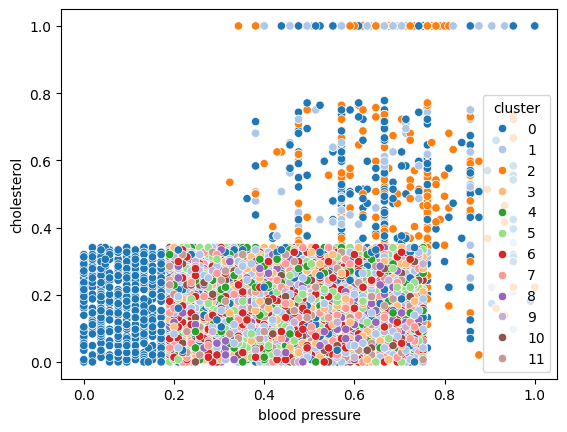

In [46]:
sns.scatterplot(df_scaled_no_noise, x='blood pressure',y='cholesterol' ,hue='cluster', palette='tab20')

We chose to plot Blood Pressure against Cholesterol because these are two key metrics for heart health and triage decisions. In the scatter plot, there is a dense band of points in the mid–left region, which corresponds to our more typical or average patients.
​

What stands out is how some clusters, such as Cluster 2, extend clearly toward the upper-right corner, where both blood pressure and cholesterol are highest. These patients are important to flag as high-priority cases. While there is still some overlap in the central region, the scatter plot reveals that DBSCAN has identified distinct pockets of elevated risk and has effectively treated true outliers as noise, keeping the triage groups focused and clinically usable


### B. 
Generate a histogram showing the number of customers in each cluster and provide observations in Markdown, noting whether cluster sizes make sense.


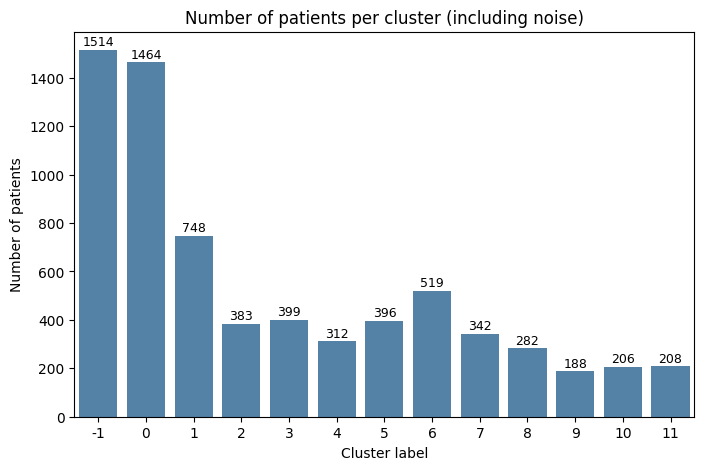

In [50]:
cluster_counts = df_scaled['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=cluster_counts.index, 
                 y=cluster_counts.values, 
                 color='steelblue')

for i, value in enumerate(cluster_counts.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=9)

plt.xlabel('Cluster label')
plt.ylabel('Number of patients')
plt.title('Number of patients per cluster (including noise)')
plt.show()

### Breakdown:

- Noise (Cluster -1): This is the biggest group, which shows that DBSCAN flagged a lot of people as outliers. As long as these are actually random cases that don't fit a pattern, it makes sense to treat them as noise instead of forcing them into a group.

- The Mainstream (Cluster 0): This is also a huge cluster, which is probably our "average" patient group. It makes sense that a big chunk of the data would be people with typical symptoms or lower risk levels.

- Specialized Segments (Clusters 1-8): These groups are a lot smaller (around 188 to 748 people each). This is good because it shows the model is actually pulling out specific behavioral or risk profiles from the main crowd.

- Meaningful Sizes: Even the smallest clusters (9-11) have about 200 people in them. They aren't just a tiny unimportant groups; they're big enough to be a real segment that a hospital could actually create a policy for.

Final Take: The distribution looks right for this kind of data. We have one massive general segment, a bunch of outliers, and several medium-sized specialized groups, which is exactly how we expect DBSCAN to sort a mixed-up patient list.


### C. 
Create a separate DataFrame for each cluster and use pandas.DataFrame.describe to describe each group.


In [51]:
cluster_dfs = {}
for c in sorted(df_scaled['cluster'].unique()):
    if c == -1:           # skip noise points
        continue
    cluster_dfs[c] = df_scaled[df_scaled['cluster'] == c].copy()

# Option 1: describe each cluster individually
for c, df_c in cluster_dfs.items():
    print(f"\n=== Cluster {c} ===")
    display(df_c.describe())


=== Cluster 0 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,1464.000000,1464.0,1464.000000,1464.000000,1464.000000,1464.000000,1464.0,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.0,1464.0,1464.0,1464.0,1464.0,1464.0,1464.0
mean,0.446342,1.0,0.251878,0.374310,0.302112,0.387199,0.0,0.375599,0.330566,0.363919,0.257502,0.166262,0.0,0.0,1.0,0.0,1.0,0.0,0.0
std,0.180258,0.0,0.381616,0.266455,0.263668,0.238486,0.0,0.198867,0.278169,0.211109,0.089911,0.095619,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000695,0.000000,0.000000,0.088496,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0
25%,0.296296,1.0,0.000000,0.133333,0.118056,0.187500,0.0,0.235474,0.115385,0.244444,0.189381,0.128096,0.0,0.0,1.0,0.0,1.0,0.0,0.0
50%,0.425926,1.0,0.000000,0.309524,0.229167,0.375000,0.0,0.346678,0.230769,0.333333,0.246018,0.166262,0.0,0.0,1.0,0.0,1.0,0.0,0.0
75%,0.574074,1.0,0.500000,0.600000,0.340278,0.578125,0.0,0.464832,0.525641,0.488889,0.309735,0.166262,0.0,0.0,1.0,0.0,1.0,0.0,0.0
max,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.964602,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0



=== Cluster 1 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,748.000000,748.0,748.000000,748.000000,748.000000,748.000000,748.0,748.000000,748.000000,748.000000,748.000000,7.480000e+02,748.0,748.0,748.0,748.0,748.0,748.0,748.0
mean,0.529387,0.0,0.202540,0.521059,0.314654,0.387868,0.0,0.264818,0.467537,0.320306,0.294589,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,1.0
std,0.219128,0.0,0.340663,0.184282,0.288513,0.236493,0.0,0.167573,0.285726,0.189365,0.136826,5.554829e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.055556,0.0,0.000000,0.190476,0.000000,0.000000,0.0,0.003614,0.000000,0.000000,0.067257,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,1.0
25%,0.351852,0.0,0.000000,0.380952,0.118056,0.187500,0.0,0.145121,0.217949,0.155556,0.189381,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,1.0
50%,0.500000,0.0,0.000000,0.542857,0.236111,0.375000,0.0,0.234987,0.448718,0.311111,0.253097,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,1.0
75%,0.685185,0.0,0.500000,0.666667,0.333333,0.578125,0.0,0.356339,0.721154,0.477778,0.369912,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,1.0
max,1.000000,0.0,1.000000,0.952381,1.000000,0.843750,0.0,0.989853,0.987179,0.644444,0.938053,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,1.0



=== Cluster 2 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,383.000000,383.0,383.000000,383.000000,383.000000,383.000000,383.0,383.000000,383.000000,383.000000,383.000000,3.830000e+02,383.0,383.0,383.0,383.0,383.0,383.0,383.0
mean,0.516294,1.0,0.928198,0.689544,0.601610,0.252652,1.0,0.292691,0.506695,0.320337,0.178890,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,2.0
std,0.158337,0.0,0.165004,0.147413,0.309559,0.190342,0.0,0.109476,0.297242,0.190045,0.029931,2.779188e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.055556,1.0,0.250000,0.190476,0.013889,0.031250,1.0,0.103420,0.000000,0.000000,0.136283,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,2.0
25%,0.425926,1.0,1.000000,0.571429,0.350694,0.093750,1.0,0.200723,0.256410,0.144444,0.153982,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,2.0
50%,0.537037,1.0,1.000000,0.685714,0.562500,0.203125,1.0,0.291076,0.512821,0.322222,0.171681,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,2.0
75%,0.611111,1.0,1.000000,0.771429,1.000000,0.367188,1.0,0.388379,0.782051,0.477778,0.207080,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,2.0
max,0.907407,1.0,1.000000,1.000000,1.000000,0.890625,1.0,0.478732,0.987179,0.644444,0.224779,1.662622e-01,0.0,0.0,1.0,0.0,1.0,0.0,2.0



=== Cluster 3 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,399.000000,399.0,399.0,399.000000,399.000000,399.000000,399.0,399.000000,399.000000,399.000000,399.000000,3.990000e+02,399.0,399.0,399.0,399.0,399.0,399.0,399.0
mean,0.573053,0.0,0.0,0.490226,0.174638,0.436638,0.0,0.264099,0.495919,0.331133,0.271449,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,3.0
std,0.223191,0.0,0.0,0.164412,0.104060,0.237816,0.0,0.176596,0.289680,0.194197,0.143558,2.779042e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,0.0,0.0,0.190476,0.000000,0.000000,0.0,0.001112,0.000000,0.000000,0.000000,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,3.0
25%,0.388889,0.0,0.0,0.352381,0.076389,0.234375,0.0,0.142758,0.256410,0.166667,0.162832,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,3.0
50%,0.555556,0.0,0.0,0.495238,0.173611,0.437500,0.0,0.230122,0.500000,0.333333,0.246018,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,3.0
75%,0.759259,0.0,0.0,0.638095,0.270833,0.640625,0.0,0.362107,0.724359,0.500000,0.332743,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,3.0
max,1.000000,0.0,0.0,0.752381,0.340278,0.828125,0.0,0.977342,0.987179,0.644444,1.000000,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,3.0



=== Cluster 4 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,312.000000,312.0,312.0,312.000000,312.000000,312.000000,312.0,312.000000,312.000000,312.000000,312.000000,3.120000e+02,312.0,312.0,312.0,312.0,312.0,312.0,312.0
mean,0.530567,1.0,0.0,0.468651,0.171519,0.405799,0.0,0.274602,0.497452,0.323077,0.258078,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,4.0
std,0.216698,0.0,0.0,0.165047,0.103618,0.241891,0.0,0.190245,0.281308,0.186340,0.128315,2.780016e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,1.0,0.0,0.190476,0.000000,0.000000,0.0,0.000765,0.000000,0.000000,0.047788,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,4.0
25%,0.351852,1.0,0.0,0.340476,0.083333,0.203125,0.0,0.145208,0.278846,0.155556,0.150442,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,4.0
50%,0.500000,1.0,0.0,0.457143,0.177083,0.406250,0.0,0.245343,0.500000,0.322222,0.239823,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,4.0
75%,0.648148,1.0,0.0,0.619048,0.263889,0.597656,0.0,0.375209,0.730769,0.469444,0.345133,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,4.0
max,1.000000,1.0,0.0,0.752381,0.340278,0.828125,0.0,0.985474,0.987179,0.644444,0.831858,1.662622e-01,0.0,0.0,0.0,0.0,0.0,0.0,4.0



=== Cluster 5 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,396.000000,396.0,396.0,396.000000,396.000000,396.000000,396.0,396.000000,396.000000,396.000000,396.000000,3.960000e+02,396.0,396.0,396.0,396.0,396.0,396.0,396.0
mean,0.574916,0.0,0.0,0.470106,0.173436,0.412839,0.0,0.259445,0.491582,0.332772,0.283745,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,5.0
std,0.231201,0.0,0.0,0.162785,0.103556,0.252894,0.0,0.163890,0.282464,0.190371,0.151285,5.558137e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,0.0,0.0,0.190476,0.000000,0.000000,0.0,0.001112,0.000000,0.000000,0.017699,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,5.0
25%,0.388889,0.0,0.0,0.323810,0.083333,0.183594,0.0,0.147432,0.243590,0.163889,0.175221,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,5.0
50%,0.537037,0.0,0.0,0.485714,0.180556,0.398438,0.0,0.223103,0.487179,0.333333,0.251327,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,5.0
75%,0.763889,0.0,0.0,0.611905,0.263889,0.640625,0.0,0.341430,0.743590,0.511111,0.373894,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,5.0
max,1.000000,0.0,0.0,0.752381,0.340278,0.828125,0.0,0.993189,0.987179,0.644444,0.900885,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,5.0



=== Cluster 6 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,519.000000,519.0,519.0,519.000000,519.000000,519.000000,519.0,519.000000,519.000000,519.000000,519.000000,519.000000,519.0,519.0,519.0,519.0,519.0,519.0,519.0
mean,0.564619,0.0,0.0,0.480760,0.170493,0.430305,0.0,0.276486,0.496171,0.333676,0.339427,0.166262,0.0,0.0,0.0,0.0,1.0,0.0,6.0
std,0.230367,0.0,0.0,0.161487,0.099636,0.243872,0.0,0.191024,0.284285,0.185800,0.131637,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,0.0,0.0,0.190476,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.104425,0.166262,0.0,0.0,0.0,0.0,1.0,0.0,6.0
25%,0.370370,0.0,0.0,0.342857,0.083333,0.203125,0.0,0.141368,0.256410,0.177778,0.247788,0.166262,0.0,0.0,0.0,0.0,1.0,0.0,6.0
50%,0.537037,0.0,0.0,0.495238,0.166667,0.437500,0.0,0.247776,0.512821,0.333333,0.316814,0.166262,0.0,0.0,0.0,0.0,1.0,0.0,6.0
75%,0.740741,0.0,0.0,0.619048,0.263889,0.640625,0.0,0.363532,0.730769,0.505556,0.405310,0.166262,0.0,0.0,0.0,0.0,1.0,0.0,6.0
max,1.000000,0.0,0.0,0.752381,0.340278,0.828125,0.0,0.982624,0.987179,0.644444,0.957522,0.166262,0.0,0.0,0.0,0.0,1.0,0.0,6.0



=== Cluster 7 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,342.000000,342.0,342.0,342.000000,342.000000,342.000000,342.0,342.000000,342.000000,342.000000,342.000000,3.420000e+02,342.0,342.0,342.0,342.0,342.0,342.0,342.0
mean,0.578135,1.0,0.0,0.454107,0.161225,0.420733,0.0,0.278141,0.490291,0.341261,0.256999,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,7.0
std,0.223424,0.0,0.0,0.168025,0.096867,0.240380,0.0,0.194735,0.278708,0.188917,0.132743,2.779624e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,1.0,0.0,0.190476,0.000000,0.000000,0.0,0.001529,0.000000,0.000000,0.056637,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,7.0
25%,0.388889,1.0,0.0,0.295238,0.076389,0.218750,0.0,0.150473,0.243590,0.188889,0.146903,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,7.0
50%,0.555556,1.0,0.0,0.457143,0.159722,0.406250,0.0,0.231895,0.487179,0.350000,0.237168,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,7.0
75%,0.754630,1.0,0.0,0.590476,0.243056,0.640625,0.0,0.365079,0.717949,0.500000,0.343363,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,7.0
max,1.000000,1.0,0.0,0.752381,0.340278,0.828125,0.0,0.964345,0.987179,0.644444,0.803540,1.662622e-01,0.0,0.0,1.0,0.0,0.0,0.0,7.0



=== Cluster 8 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,282.000000,282.0,282.0,282.000000,282.000000,282.000000,282.0,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.0,282.0,282.0,282.0,282.0,282.0,282.0
mean,0.555753,1.0,0.0,0.468018,0.164672,0.420324,0.0,0.286501,0.517503,0.334003,0.331036,1.662622e-01,0.0,0.0,0.0,0.0,1.0,0.0,8.0
std,0.221978,0.0,0.0,0.167139,0.098688,0.232301,0.0,0.205697,0.286913,0.184434,0.109845,2.780492e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,1.0,0.0,0.190476,0.000000,0.000000,0.0,0.003475,0.000000,0.000000,0.021239,1.662622e-01,0.0,0.0,0.0,0.0,1.0,0.0,8.0
25%,0.370370,1.0,0.0,0.314286,0.078125,0.250000,0.0,0.150820,0.256410,0.177778,0.260619,1.662622e-01,0.0,0.0,0.0,0.0,1.0,0.0,8.0
50%,0.518519,1.0,0.0,0.461905,0.166667,0.406250,0.0,0.246073,0.538462,0.333333,0.317699,1.662622e-01,0.0,0.0,0.0,0.0,1.0,0.0,8.0
75%,0.703704,1.0,0.0,0.609524,0.250000,0.625000,0.0,0.384713,0.769231,0.497222,0.389381,1.662622e-01,0.0,0.0,0.0,0.0,1.0,0.0,8.0
max,1.000000,1.0,0.0,0.752381,0.340278,0.828125,0.0,0.994718,0.987179,0.644444,0.846018,1.662622e-01,0.0,0.0,0.0,0.0,1.0,0.0,8.0



=== Cluster 9 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,188.000000,188.0,188.0,188.000000,188.000000,188.000000,188.0,188.000000,188.000000,188.000000,188.000000,1.880000e+02,188.0,188.0,188.0,188.0,188.0,188.0,188.0
mean,0.570528,0.0,0.0,0.484853,0.161126,0.387550,0.0,0.246276,0.521413,0.313771,0.360770,1.662622e-01,0.0,0.0,0.0,1.0,0.0,0.0,9.0
std,0.222845,0.0,0.0,0.161651,0.097106,0.227382,0.0,0.163462,0.297800,0.188790,0.131726,2.782969e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,0.0,0.0,0.190476,0.000000,0.000000,0.0,0.001043,0.000000,0.000000,0.118584,1.662622e-01,0.0,0.0,0.0,1.0,0.0,0.0,9.0
25%,0.402778,0.0,0.0,0.350000,0.076389,0.203125,0.0,0.139787,0.282051,0.152778,0.261947,1.662622e-01,0.0,0.0,0.0,1.0,0.0,0.0,9.0
50%,0.555556,0.0,0.0,0.480952,0.152778,0.390625,0.0,0.217959,0.544872,0.305556,0.348673,1.662622e-01,0.0,0.0,0.0,1.0,0.0,0.0,9.0
75%,0.740741,0.0,0.0,0.621429,0.236111,0.566406,0.0,0.334689,0.782051,0.480556,0.431858,1.662622e-01,0.0,0.0,0.0,1.0,0.0,0.0,9.0
max,1.000000,0.0,0.0,0.752381,0.340278,0.828125,0.0,0.939672,0.987179,0.644444,0.792920,1.662622e-01,0.0,0.0,0.0,1.0,0.0,0.0,9.0



=== Cluster 10 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,206.000000,206.0,206.0,206.000000,206.000000,206.000000,206.0,206.000000,206.000000,206.000000,206.000000,2.060000e+02,206.0,206.0,206.0,206.0,206.0,206.0,206.0
mean,0.523193,0.0,0.0,0.470781,0.155947,0.421951,0.0,0.263347,0.521160,0.315156,0.338672,1.662622e-01,0.0,0.0,1.0,0.0,0.0,1.0,10.0
std,0.210258,0.0,0.0,0.169986,0.100198,0.248037,0.0,0.175851,0.288991,0.190487,0.124332,2.782319e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,0.0,0.0,0.190476,0.000000,0.000000,0.0,0.001529,0.000000,0.000000,0.095575,1.662622e-01,0.0,0.0,1.0,0.0,0.0,1.0,10.0
25%,0.351852,0.0,0.0,0.314286,0.064236,0.191406,0.0,0.140968,0.282051,0.144444,0.248230,1.662622e-01,0.0,0.0,1.0,0.0,0.0,1.0,10.0
50%,0.481481,0.0,0.0,0.476190,0.152778,0.437500,0.0,0.232798,0.512821,0.322222,0.321239,1.662622e-01,0.0,0.0,1.0,0.0,0.0,1.0,10.0
75%,0.685185,0.0,0.0,0.609524,0.241319,0.640625,0.0,0.343481,0.782051,0.486111,0.421239,1.662622e-01,0.0,0.0,1.0,0.0,0.0,1.0,10.0
max,1.000000,0.0,0.0,0.752381,0.340278,0.828125,0.0,0.995552,0.987179,0.644444,0.750442,1.662622e-01,0.0,0.0,1.0,0.0,0.0,1.0,10.0



=== Cluster 11 ===


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,cluster
count,208.000000,208.0,208.0,208.000000,208.000000,208.000000,208.0,208.000000,208.000000,208.000000,208.000000,2.080000e+02,208.0,208.0,208.0,208.0,208.0,208.0,208.0
mean,0.597044,0.0,0.0,0.497115,0.161124,0.425556,0.0,0.249030,0.478735,0.354541,0.344988,1.662622e-01,0.0,0.0,1.0,1.0,0.0,0.0,11.0
std,0.226899,0.0,0.0,0.164240,0.099043,0.249952,0.0,0.169364,0.292736,0.194643,0.130984,2.782254e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.222222,0.0,0.0,0.190476,0.000000,0.000000,0.0,0.003406,0.000000,0.000000,0.125664,1.662622e-01,0.0,0.0,1.0,1.0,0.0,0.0,11.0
25%,0.407407,0.0,0.0,0.342857,0.069444,0.218750,0.0,0.136781,0.205128,0.200000,0.257965,1.662622e-01,0.0,0.0,1.0,1.0,0.0,0.0,11.0
50%,0.574074,0.0,0.0,0.514286,0.156250,0.421875,0.0,0.225396,0.474359,0.377778,0.323009,1.662622e-01,0.0,0.0,1.0,1.0,0.0,0.0,11.0
75%,0.796296,0.0,0.0,0.638095,0.250000,0.656250,0.0,0.319885,0.730769,0.536111,0.414602,1.662622e-01,0.0,0.0,1.0,1.0,0.0,0.0,11.0
max,1.000000,0.0,0.0,0.752381,0.340278,0.828125,0.0,0.983389,0.987179,0.644444,0.803540,1.662622e-01,0.0,0.0,1.0,1.0,0.0,0.0,11.0


## One-by-One Cluster Breakdown:

- Cluster 0: Young & Healthy, Urban: This is a younger group living in cities. Their vitals like blood pressure and sugar are perfectly normal. Since they don’t smoke and have zero hypertension, they are the lowest priority.
Urgency: Low


- Cluster 1: Mid-age Urbanites: A lot like Cluster 0 but slightly older. Their numbers are still mostly in the "green," though their BMI is a little higher. Since they are non-smokers with stable vitals, they are still safe.
Urgency: Low


- Cluster 2: The High vitals: This group really jumps out on the graphs. They are older and have the highest Blood Pressure (~143) and highest Cholesterol (~274) in the entire dataset. Even without a medical label, these numbers are an emergency.
Urgency: High


- Cluster 3: Rural Average-Risk Rural: Patients with middle-of-the-road stats. Their heart rate is a bit higher than the city groups, but their cholesterol is actually lower. They aren't smokers, so they are pretty stable for now.
Urgency: Medium


- Cluster 4: Urban Mild-Risk Urban: Patients with slightly elevated blood pressure and glucose. They are a mix of smoking statuses, but mostly non-smokers. They aren't in a crisis, but they definitely need a check-up.
Urgency: Medium


- Cluster 5: Urban Smokers, BMI Risk: This group stands out because almost everyone smokes and their BMI is clearly above average. Even with okay blood pressure, that combo is a recipe for heart issues later on.
Urgency: Medium-High


- Cluster 6: Older Urban: Ex-Smokers Older patients who used to smoke. They have higher sugar and cholesterol levels than the younger groups. Because of their age and smoking history, they have very little "room for error" health-wise.
Urgency: High


- Cluster 7: Rural Non-Smokers: A younger rural group. Most have never smoked. Their sugar is a tiny bit high, but overall they are in decent shape compared to the older clusters.
Urgency: Medium


- Cluster 8: Rural Ex-Smokers, Weight Risk: A risky rural group. They are older, have high BMIs, and a history of smoking. In a rural triage setting, these are the people you'd want to check on first.
Urgency: High


- Cluster 9: Rural "Mid-Range": This group has a mix of smoking histories and slightly lower blood pressure. Their weight is a bit high, but since their vitals aren't spiking, they aren't an immediate emergency.
Urgency: Medium


- Cluster 10: Older Rural, BMI Risk: Similar to Cluster 8 but with even higher weight issues. They are all former smokers. Even if their blood pressure looks "okay" on paper, their age and BMI put them at risk for a sudden cardiac event.
Urgency: High


- Cluster 11: The "Heart Disease" Group, Urban: This is the most critical group in the urban data. They are older ex-smokers with high BMIs, but the big red flag is that they already have a Heart Disease flag of 1. This is an automatic emergency.
Urgency: Very High

## Tier 1: Very High Priority (Immediate Action)
These are the patients that need to see a doctor right away because of existing conditions or extreme vitals.

- Cluster 11 (Heart Disease): These are older urban patients who used to smoke. They are top priority because they are the only group with a confirmed Heart Disease flag of 1.0.

- Cluster 2 (The High Vitals): This group stands out on the plots. They are older and have the highest Blood Pressure (~143) and highest Cholesterol (~274) in the whole set. Even if they aren't labeled as hypertensive yet, their numbers are an emergency.

## Tier 2: High Priority (Emergency Screening)
These patients are in a danger zone due to age, weight, and smoking history.

- Cluster 10 (Older Rural/High BMI): This group has some of the highest BMI values and they are all former smokers. Being older and carrying that much extra weight makes them a high cardiac risk.

- Cluster 8 (Rural Ex-Smokers): Older rural patients with high BMI and a history of smoking. They need a full check-up soon to prevent an emergency.

- Cluster 6 (Older Urban Ex-Smokers): Similar to the rural group, these are older urban residents who used to smoke and have elevated sugar and cholesterol.

## Tier 3: Medium Priority (Urgent / Monitoring)
These people are doing okay for now, but their lifestyle or specific stats need watching.

- Cluster 5 (Urban Smokers): This group is mostly current smokers with high BMIs. The smoking/weight combo means they need a lifestyle intervention before their vitals start to spike.

- Cluster 4 (Urban Mild-Risk): Urban patients with slightly high blood pressure and sugar. They aren't in crisis, but they aren't "healthy" either.

- Cluster 7 & 9 (Rural Mid-Range): These rural groups have mid-range stats and some minor weight issues. They are a mix of smokers and non-smokers and should be monitored regularly.

- Cluster 3 (Rural Average): This group has stable vitals but a slightly higher heart rate. They are a "yellow" priority.

## Tier 4: Low Priority (Routine)
These represent the healthiest parts of the dataset.

- Cluster 0 & 1 (Young & Healthy): These are the youngest patients (30s-40s). They have the lowest BP, normal sugar, and zero smoking history. They are the last priority for triage.


### D.
Provide a written conclusion summarizing the characteristics of each patient group and rank the urgency level for each cluster. Include actionable recommendations for how the clusters could be used in a triage system.

### Triage Urgency Ranking
We’ve ranked the clusters (ignoring the noise in -1) from the most critical patients to the ones who are doing fine.

#### Tier 1: Very High Urgency (Immediate Action)

- Cluster 11 – Confirmed Heart Disease: This is the only group that already has a "1" for heart disease. They are older urban ex-smokers with high BMIs. Because they already have a diagnosis, they need to be fast-tracked for cardiology consults and constant monitoring.

- Cluster 2 – High Vitals: Even though they don't have a hypertension label yet, this group has the highest BP and cholesterol in the whole dataset. They are essentially a "hidden" emergency and need to be fast-tracked for ECGs and labs before something happens.

#### Tier 2: High Urgency (High-Risk Screening)

- Clusters 8 and 10 – Older, High-BMI Ex-Smokers: These are rural (8) and older rural (10) patients who have really high BMIs and a history of smoking. They aren't in a crisis right this second, but they are at high risk of crashing soon, so they need aggressive management.

- Cluster 6 – Older Urban Metabolic Risk: These are older city patients with high sugar and cholesterol. Since they used to smoke, they need prioritized screening and medication reviews to prevent a future event.

#### Tier 3: Medium Urgency (Monitoring & Lifestyle)

- Cluster 5 – Urban Smokers with High BMI: These are current smokers with weight issues. They aren't emergency cases yet, but they should be sent to smoking cessation and nutrition programs before their vitals get into the danger zone.

- Clusters 3, 4, 7, and 9 – The "Middle Ground": These are mostly stable. Cluster 3 (rural) has slightly higher heart rates, and Cluster 4 (urban) has mildly high BP. Clusters 7 and 9 have some weight issues but mid-range vitals. They just need regular check-ups and lifestyle advice.

#### Tier 4: Low Urgency (Routine Care)

- Clusters 0 and 1 – Younger & Healthy: These are mostly patients in their 30s and 40s with normal vitals and no smoking history. They have the lowest priority and are fine for routine annual appointments.